# Home-Field Advantage model

Create an 'elo' score (concept borrowed from chess) for teams based on 'fivethirtyeight' website. Compare matchups and favor the home team.

In [54]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup

def find_pitchers(team):
    """Import pitching rosters for the 'major cities' teams
    
    Args:
      team (str): the name of the target baseball team
    
    Returns:
      pitchers (list): each pitcher on the 'team's depth chart
    """
    # download contents from the webpage
    url = "https://www.espn.com/mlb/team/depth/_/name/{}/"
    data = requests.get(url.format(team)).text
    soup = BeautifulSoup(data, 'html.parser')
    
    # a list of all tables
    tables = soup.find_all('table')
    table = soup.find('table', class_='Table')
    
    df = pd.DataFrame(columns=['starter','2nd','3rd','4th','5th'])
    
    # collecting data
    for row in tables[1].tbody.find_all('tr'):
        columns = row.find_all('td')
        if (columns != []):
            starter = columns[0].text.strip()
            second = columns[1].text.strip()
            third = columns[2].text.strip()
            fourth = columns[3].text.strip()
            fifth = columns[4].text.strip()

            df = df.append({
                'starter': starter,
                '2nd': second,
                '3rd': third,
                '4th': fourth,
                '5th': fifth
            }, ignore_index=True)

    pitchers = list(df.iloc[0]) + list(df.iloc[1])
    return pitchers

In [55]:
# generate an ELO dictionary

elo_url = "https://projects.fivethirtyeight.com/2022-mlb-predictions/"
page = requests.get(elo_url).text

soup = BeautifulSoup(page, 'html.parser')

# check that scraper is working properly
print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))
    
# a list of all tables
tables = soup.find_all('table')
# Looking for the table with the class 'Table'
table = soup.find('table', class_='index-standings-table')

# create elo_scores df by web-scraping FiveThirtyEight
elo_scores = pd.DataFrame(columns=['team','division','rating','1wk_change','run_diff','make_playoffs','win_division','win_ws'])

#collecting data
for row in table.tbody.find_all('tr'):
    columns = row.find_all('td')
    
    if (columns != []):
        team = columns[0].text.strip()
        div = columns[1].text.strip()
        rating = columns[2].text.strip()
        week_ch = columns[3].text.strip()
        run_diff = columns[4].text.strip()
        make_playoffs = columns[5].text.strip()
        win_div = columns[6].text.strip()
        win_ws = columns[7].text.strip()
        
        elo_scores = elo_scores.append({
            'team': team,
            'division': div,
            'rating': rating,
            '1wk_change': week_ch,
            'run_diff': run_diff,
            'make_playoffs': make_playoffs,
            'win_division': win_div,
            'win_ws': win_ws
        }, ignore_index=True)

elo_scores = elo_scores.drop(['division','run_diff','make_playoffs','win_division','win_ws'], axis=1)

elo_scores['team'] = elo_scores['team'].str.extract(r'([a-zA-Z]+)')
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Red Sox' if (x == 'Red') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'White Sox' if (x == 'White') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Blue Jays' if (x == 'Blue') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Dbacks' if (x == 'Diamondbacks') else x)

elo_scores = elo_scores.sort_values(by=['rating'], ascending=False).reset_index()
elo_scores = elo_scores.drop(['index'], axis=1)

# create a dictionry to map the gameDay df when ready
elo_dict = elo_scores.set_index('team')['rating'].to_dict()

elo_scores

Classes of each table:
['index-standings-table', 'arrow-sort']


,team,rating,1wk_change
0,Dodgers,1596,+5
1,Yankees,1589,-1
2,Astros,1564,+1
3,Braves,1560,+5
4,Mets,1545,+3
5,Red Sox,1539,-4
6,Blue Jays,1535,-10
7,Phillies,1534,+1
8,Brewers,1533,-6
9,Padres,1533,-9


In [56]:
url = "https://www.espn.com/mlb/schedule"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'lxml')

tag = 'div'
class_ = 'class'
table_name = 'ResponsiveTable'
tables = soup.find_all('{}'.format(tag), {'{}'.format(class_):'{}'.format(table_name)})
table = tables[1]

table_date = table.find('div', {'class':'Table__Title'}).text
print(table_date)

gameDay = pd.DataFrame(columns=['away','home','time','blank','pitching','tickets','odds'])

for row in table.find_all('tr')[1:]:
    data = row.find_all('td')
    if (data != []):
        row_data = [td.text.strip() for td in data]
        length = len(gameDay)
        gameDay.loc[length] = row_data

gameDay = gameDay.drop(['blank','tickets','odds'], axis=1)
gameDay

Tuesday, July 12, 2022 


,away,home,time,pitching
0,Chicago,@ Cleveland,1:10 PM,Davis Martin vs Shane Bieber
1,Pittsburgh,@ Miami,6:40 PM,Chris Stratton vs Daniel Castano
2,Cincinnati,@ New York,7:05 PM,Graham Ashcraft vs Gerrit Cole
3,Seattle,@ Washington,7:05 PM,Chris Flexen vs Josiah Gray
4,Philadelphia,@ Toronto,7:07 PM,Andrew Bellatti vs Jose Berrios
5,Boston,@ Tampa Bay,7:10 PM,Chris Sale vs Corey Kluber
6,Chicago,@ Cleveland,7:10 PM,Dylan Cease vs Konnor Pilkington
7,New York,@ Atlanta,7:20 PM,David Peterson vs Spencer Strider
8,Milwaukee,@ Minnesota,7:40 PM,Jason Alexander vs Josh Winder
9,Los Angeles,@ St. Louis,7:45 PM,Mitch White vs Matthew Liberatore


In [57]:
# cleaning 'gameDay'
## this cell should only be ran once
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('@  ',''))
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('@ ',''))
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('\xa0',''))
gameDay['away_pitcher'] = gameDay['pitching'].apply(lambda x: x.split(' vs ')[0])
gameDay['home_pitcher'] = gameDay['pitching'].apply(lambda x: x.split(' vs ')[1])
gameDay = gameDay.drop(['pitching'], axis=1)
gameDay

,away,home,time,away_pitcher,home_pitcher
0,Chicago,Cleveland,1:10 PM,Davis Martin,Shane Bieber
1,Pittsburgh,Miami,6:40 PM,Chris Stratton,Daniel Castano
2,Cincinnati,New York,7:05 PM,Graham Ashcraft,Gerrit Cole
3,Seattle,Washington,7:05 PM,Chris Flexen,Josiah Gray
4,Philadelphia,Toronto,7:07 PM,Andrew Bellatti,Jose Berrios
5,Boston,Tampa Bay,7:10 PM,Chris Sale,Corey Kluber
6,Chicago,Cleveland,7:10 PM,Dylan Cease,Konnor Pilkington
7,New York,Atlanta,7:20 PM,David Peterson,Spencer Strider
8,Milwaukee,Minnesota,7:40 PM,Jason Alexander,Josh Winder
9,Los Angeles,St. Louis,7:45 PM,Mitch White,Matthew Liberatore


In [58]:
# major city teams have the issue of redundency
# assembling the pitchers allows us to check which team is which
teams = ['nyy','nym','lad','laa','chc','chw']
nyy_pitchers = find_pitchers('nyy')
nym_pitchers = find_pitchers('nym')
lad_pitchers = find_pitchers('lad')
laa_pitchers = find_pitchers('laa')
chc_pitchers = find_pitchers('chc')
chw_pitchers = find_pitchers('chw')

# check on a certain city
# print(nyy_pitchers)
# print(nym_pitchers)

# check 'away' column for Chicago
index_count = 0
for city in gameDay['away']:
    if city == 'Chicago':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in chc_pitchers:
            gameDay['away'][index_count-1] = 'Cubs'
        elif gameDay['away_pitcher'][index_count-1] in chw_pitchers:
            gameDay['away'][index_count-1] = 'White Sox'
        else:
            print('***Error with Chicago-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for Chicago
index_count = 0
for city in gameDay['home']:
    if city == 'Chicago':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in chc_pitchers:
            gameDay['home'][index_count-1] = 'Cubs'
        elif gameDay['home_pitcher'][index_count-1] in chw_pitchers:
            gameDay['home'][index_count-1] = 'White Sox'
        else:
            print('***Error with Chicago-Home***')
    else:
        index_count += 1
        continue

# check 'away' column for New York
index_count = 0
for city in gameDay['away']:
    if city == 'New York':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in nyy_pitchers:
            gameDay['away'][index_count-1] = 'Yankees'
        elif gameDay['away_pitcher'][index_count-1] in nym_pitchers:
            gameDay['away'][index_count-1] = 'Mets'
        else:
            print('***Error with New York-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for New York
index_count = 0
for city in gameDay['home']:
    if city == 'New York':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in nyy_pitchers:
            gameDay['home'][index_count-1] = 'Yankees'
        elif gameDay['home_pitcher'][index_count-1] in nym_pitchers:
            gameDay['home'][index_count-1] = 'Mets'
        else:
            print('***Error with New York-Home***')
    else:
        index_count += 1
        continue

# check 'away' column for Los Angeles
index_count = 0
for city in gameDay['away']:
    if city == 'Los Angeles':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in lad_pitchers:
            gameDay['away'][index_count-1] = 'Dodgers'
        elif gameDay['away_pitcher'][index_count-1] in laa_pitchers:
            gameDay['away'][index_count-1] = 'Angels'
        else:
            print('***Error with Los Angeles-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for Los Angeles
index_count = 0
for city in gameDay['home']:
    if city == 'Los Angeles':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in lad_pitchers:
            gameDay['home'][index_count-1] = 'Dodgers'
        elif gameDay['home_pitcher'][index_count-1] in laa_pitchers:
            gameDay['home'][index_count-1] = 'Angels'
        else:
            print('***Error with Los Angeles-Home***')
    else:
        index_count += 1
        continue
gameDay

***Error with Chicago-Away***
***Error with Chicago-Home***
***Error with Los Angeles-Away***


,away,home,time,away_pitcher,home_pitcher
0,Chicago,Cleveland,1:10 PM,Davis Martin,Shane Bieber
1,Pittsburgh,Miami,6:40 PM,Chris Stratton,Daniel Castano
2,Cincinnati,Yankees,7:05 PM,Graham Ashcraft,Gerrit Cole
3,Seattle,Washington,7:05 PM,Chris Flexen,Josiah Gray
4,Philadelphia,Toronto,7:07 PM,Andrew Bellatti,Jose Berrios
5,Boston,Tampa Bay,7:10 PM,Chris Sale,Corey Kluber
6,White Sox,Cleveland,7:10 PM,Dylan Cease,Konnor Pilkington
7,Mets,Atlanta,7:20 PM,David Peterson,Spencer Strider
8,Milwaukee,Minnesota,7:40 PM,Jason Alexander,Josh Winder
9,Los Angeles,St. Louis,7:45 PM,Mitch White,Matthew Liberatore


In [59]:
# use this cell to hard-correct any errors with major cities, if necessary
gameDay['away'][0] = 'White Sox'
gameDay['home'][10] = 'Cubs'
gameDay['away'][9] = 'Dodgers'
gameDay

,away,home,time,away_pitcher,home_pitcher
0,White Sox,Cleveland,1:10 PM,Davis Martin,Shane Bieber
1,Pittsburgh,Miami,6:40 PM,Chris Stratton,Daniel Castano
2,Cincinnati,Yankees,7:05 PM,Graham Ashcraft,Gerrit Cole
3,Seattle,Washington,7:05 PM,Chris Flexen,Josiah Gray
4,Philadelphia,Toronto,7:07 PM,Andrew Bellatti,Jose Berrios
5,Boston,Tampa Bay,7:10 PM,Chris Sale,Corey Kluber
6,White Sox,Cleveland,7:10 PM,Dylan Cease,Konnor Pilkington
7,Mets,Atlanta,7:20 PM,David Peterson,Spencer Strider
8,Milwaukee,Minnesota,7:40 PM,Jason Alexander,Josh Winder
9,Dodgers,St. Louis,7:45 PM,Mitch White,Matthew Liberatore


In [60]:
# change city name to team name and update 'gameDay'
new_dict = {
    'Tampa Bay': 'Rays','Boston': 'Red Sox','New York': 'Yankees','Toronto': 'Blue Jays','Baltimore': 'Orioles',
    'Chicago': 'White Sox','Cleveland': 'Guardians','Detroit': 'Tigers','Kansas City': 'Royals','Minnesota': 'Twins',
    'Houston': 'Astros','Seattle': 'Mariners','Oakland': 'Athletics','Los Angeles': 'Angels','Texas': 'Rangers',
    'Atlanta': 'Braves','Philadelphia': 'Phillies','New York': 'Mets','Miami': 'Marlins','Washington': 'Nationals',
    'Milwaukee': 'Brewers','St. Louis': 'Cardinals','Cincinnati': 'Reds','Chicago': 'Cubs','Pittsburgh': 'Pirates',
    'San Francisco': 'Giants','Los Angeles': 'Dodgers','San Diego': 'Padres','Colorado': 'Rockies','Arizona': 'Dbacks'
} # trouble spots: New York, Chicago, Los Angeles. Doubles will cause inaccuracies # bug fixed

gameDay = gameDay.replace({'away': new_dict})
gameDay = gameDay.replace({'home': new_dict})
gameDay['a_elo'] = gameDay['away']
gameDay = gameDay.replace({'a_elo': elo_dict})
gameDay['h_elo'] = gameDay['home']
gameDay = gameDay.replace({'h_elo': elo_dict})
gameDay['adv'] = pd.to_numeric(gameDay['h_elo']) - pd.to_numeric(gameDay['a_elo'])
gameDay

,away,home,time,away_pitcher,home_pitcher,a_elo,h_elo,adv
0,White Sox,Guardians,1:10 PM,Davis Martin,Shane Bieber,1517,1494,-23
1,Pirates,Marlins,6:40 PM,Chris Stratton,Daniel Castano,1441,1497,56
2,Reds,Yankees,7:05 PM,Graham Ashcraft,Gerrit Cole,1469,1589,120
3,Mariners,Nationals,7:05 PM,Chris Flexen,Josiah Gray,1511,1442,-69
4,Phillies,Blue Jays,7:07 PM,Andrew Bellatti,Jose Berrios,1534,1535,1
5,Red Sox,Rays,7:10 PM,Chris Sale,Corey Kluber,1539,1529,-10
6,White Sox,Guardians,7:10 PM,Dylan Cease,Konnor Pilkington,1517,1494,-23
7,Mets,Braves,7:20 PM,David Peterson,Spencer Strider,1545,1560,15
8,Brewers,Twins,7:40 PM,Jason Alexander,Josh Winder,1533,1523,-10
9,Dodgers,Cardinals,7:45 PM,Mitch White,Matthew Liberatore,1596,1513,-83


In [61]:
# predicted winners/losers put into lists
win_pred = []

# bet on good, home teams
for home in gameDay['home']:
    if home in list(elo_scores['team'].head(11)):
        win_pred.append(home)

# bet on home teams with a significant chance to win at home
for i in range(len(gameDay)):
    if gameDay['adv'][i] > 50:
        win_pred.append(gameDay['home'][i])
        
# compile a list of teams to bet against
lose_pred = []
for away in gameDay['away']:
    if away in list(elo_scores['team'].iloc[-10:]):
        lose_pred.append(away)

# bet on away teams with a significant chance to win on the road
for i in range(len(gameDay)):
    if gameDay['adv'][i] < -75:
        win_pred.append(gameDay['away'][i])
        
print('Winners: ', sorted(win_pred))
print('Losers: ', sorted(lose_pred))

Winners:  ['Blue Jays', 'Braves', 'Dodgers', 'Marlins', 'Padres', 'Rangers', 'Rays', 'Yankees', 'Yankees']
Losers:  ['Athletics', 'Dbacks', 'Orioles', 'Pirates', 'Reds', 'Tigers']


Difference value:  15
Current Bankroll:  1407.64
DataFrame 1 Shape:  (947, 3)
X1:  (932, 1)
y1:  (932, 1)
X2:  (167, 1)
y2:  (167, 1)
Slope 1:      -0.6350199877553719 
Intercept 1:  1787.22227640313
Slope 2:      0.6188066981355707 
Intercept 2:  931.1181475259461


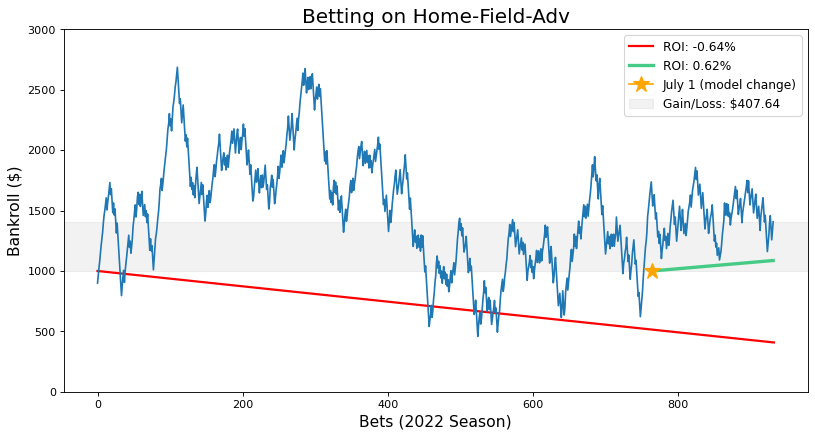

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# read in the Google Sheets - Bets .csv and clean it up
bets = pd.read_csv("/Users/chasecrawford/Data Science/MLB prediction - '538' power ranking - Bets.csv", header=5)
bets = bets.drop(0).reset_index()
bets = bets.drop(['index','Date','predicted','bet on','money line','Unnamed: 7'], axis=1)

# 'dif' here figures out how many rows need to be left off the end of the sheet (unpredicted games)
bank_len = [item for item in bets['bankroll'] if not(pd.isnull(item)) == True]
dif = len(bets) - len(bank_len)
print("Difference value: ", dif)

# prepare data for regression
x1 = pd.DataFrame(bets.index)[:-dif]
y1 = bets[['bankroll']][:-dif]

# prepare data for post-July regression
x2 = pd.DataFrame(bets.index)[765:-dif]
y2 = bets[['bankroll']][765:-dif]

# print current bankroll
latest_bankroll = bets['bankroll'].iloc[-(dif+1)]
print("Current Bankroll: ", latest_bankroll)

# print the size of DataFrame 1, to ensure ML compatability
bets_length1 = x1.shape[0]
print("DataFrame 1 Shape: ", bets.shape)
print("X1: ", x1.shape)
print("y1: ", y1.shape)

# print the size of DataFrame 2, to ensure ML compatability
bets_length2 = x2.shape[0]
print("X2: ", x2.shape)
print("y2: ", y2.shape)

# set plot size
plt.figure(figsize=(12, 6), dpi=80)

# perform LinearRegression 1
# find elements of y=mx+b for graphing purposes
lr = LinearRegression()
lr.fit(x1, y1)
m = float(lr.coef_)
#b = float(lr.intercept_)
b = 1000
print("Slope 1:     ",m,"\nIntercept 1: ", float(lr.intercept_))
x = np.linspace(0, bets_length1, 1000)
y = m*x + b
plt.plot(x, y, 
         '-r', # color and line-type
         label="ROI: {:.2f}%".format(m), 
         linewidth=2
        )

# perform LinearRegression 1
# find elements of y=mx+b for graphing purposes
lr2 = LinearRegression()
lr2.fit(x2, y2)
m2 = float(lr2.coef_)
#b = float(lr.intercept_)
print("Slope 2:     ",m2,"\nIntercept 2: ", float(lr2.intercept_))
x = np.linspace(0, bets_length2, 1000) + 764
y3 = m2*x3 + b
plt.plot(x, y3, 
         '#45CB85', # color 
         label="ROI: {:.2f}%".format(m2), 
         linewidth=3
        )

# graph settings
plt.plot(bets['bankroll'])
plt.title("Betting on Home-Field-Adv", fontsize=18)
plt.xlabel("Bets (2022 Season)", fontsize=14)
plt.xticks()
plt.ylabel("Bankroll (\$)", fontsize=14)
plt.axhspan(1000, latest_bankroll, 
            0, len(bets), 
            color="grey", alpha=0.1, 
            label="Gain/Loss: \${:.2f}".format(latest_bankroll-1000)
           )
plt.plot(764, 1000, 
         label='July 1 (model change)', 
         marker='*', markersize=15, 
         color='orange'
        )
plt.legend(fontsize=11)
plt.ylim(0,3000)
plt.show()